# Lab 9 - Association Rule Mining



Association rule mining started off as market basket analysis, which looked at items customers bought frequently together. Through association rule mining, we can discover interesting associations that help business decision-making processes such as catalog design, cross-marketing, customer shopping behavior analysis and more.

Basic Principle:

- **Frequent patterns** are itemsets that appear frequently in a dataset (e.g. transaction records).
- Items that are frequently associated (e.g. purchased) together can be represented as **association rules**
- **Support** and **Confidence** are measures of rule interestingness

**Support** is essentially the percentage of orders/transactions containing the itemset, given by the following formula:

$$\mathrm{Support}(A \Rightarrow B)=\dfrac{|A \cup B|}{n}$$

Given two item sets, A and B, **Confidence** measures the percentage of times that B was purchased, given that A was purchased. In other words, it measures how *confident* we are that B would follow A. This is calculated using the following formula:

$$\mathrm{Confidence}(A \Rightarrow B)=\dfrac{\mathrm{Support}(A \cup B)}{\mathrm{Support}(A)}$$

## Import Libraries and Load Dataset

In [1]:
# Uncomment and execute this cell if running locally or on Colab
# to install the mlxtend package for assoc. rule mining

#!pip install mlxtend --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [3]:
try:
    df = pd.read_csv('../data/groceries_dataset.csv')
except:
    df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/Summer2025/refs/heads/main/data/groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## Exploratoy Data Analysis & Data Pre-processing

Converting the date column to a `datetime` datatype allows us to access useful datetime properties like day and month later on.

In this simple example we passed the `dayfirst` parameter for `pd.to_datetime` to correctly parse the date. Other parameters like `utc` can also be passed, in order to have the transaction time in addition to the date. This should always be handled in realistic applications, since you'll have to consider the data's date format (e.g., MM/DD or DD/MM), timezone, business days,...

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


Printing out the different varieties of products being sold along with the products themselves allows us to better understand the data we're dealing with. For actual retail stores with potentially thousands of different products, we could go for random sampling instead.

In [7]:
print("There are {} products:".format(df['itemDescription'].nunique()))
df['itemDescription'].unique()

There are 167 products:


array(['tropical fruit', 'whole milk', 'pip fruit', 'other vegetables',
       'rolls/buns', 'pot plants', 'citrus fruit', 'beef', 'frankfurter',
       'chicken', 'butter', 'fruit/vegetable juice',
       'packaged fruit/vegetables', 'chocolate', 'specialty bar',
       'butter milk', 'bottled water', 'yogurt', 'sausage', 'brown bread',
       'hamburger meat', 'root vegetables', 'pork', 'pastry',
       'canned beer', 'berries', 'coffee', 'misc. beverages', 'ham',
       'turkey', 'curd cheese', 'red/blush wine',
       'frozen potato products', 'flour', 'sugar', 'frozen meals',
       'herbs', 'soda', 'detergent', 'grapes', 'processed cheese', 'fish',
       'sparkling wine', 'newspapers', 'curd', 'pasta', 'popcorn',
       'finished products', 'beverages', 'bottled beer', 'dessert',
       'dog food', 'specialty chocolate', 'condensed milk', 'cleaner',
       'white wine', 'meat', 'ice cream', 'hard cheese', 'cream cheese ',
       'liquor', 'pickled vegetables', 'liquor (appetizer

A few visualizations to better understand the business and the products that it sells.

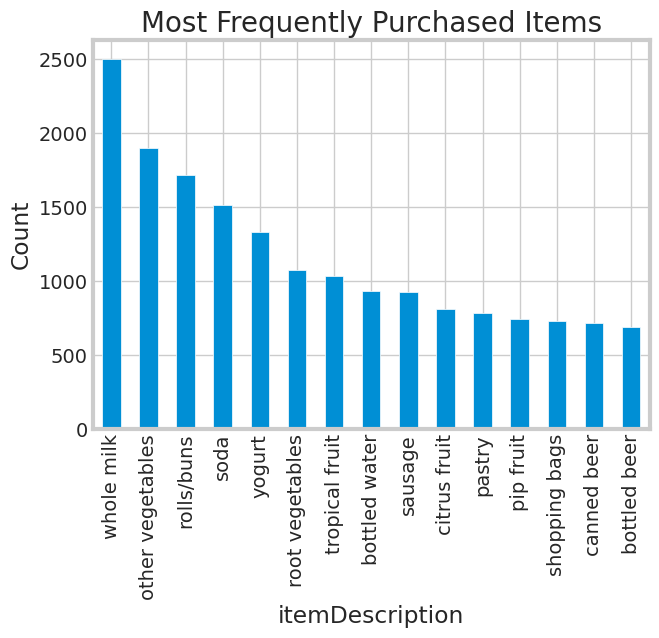

In [8]:
ax = df['itemDescription'].value_counts().nlargest(15).plot(kind='bar')
ax.set_title('Most Frequently Purchased Items', size=20)
ax.set_ylabel('Count');

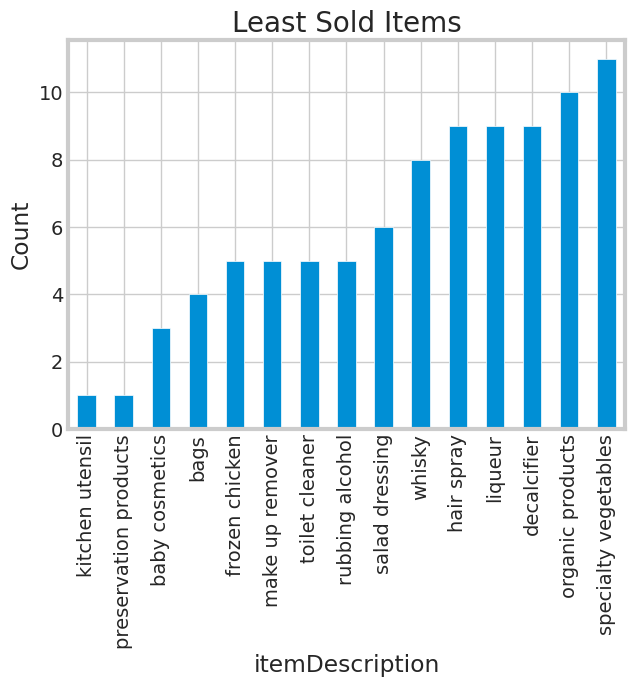

In [9]:
ax = df['itemDescription'].value_counts().nsmallest(15).plot(kind='bar')
ax.set_title('Least Sold Items', size=20)
ax.set_ylabel('Count');

Since the `'Date'` column is of type `datetime`, we can group the data by each month. It's possible to also group the data by weekday, or even by hour (if we had the transaction time in addition to the date).

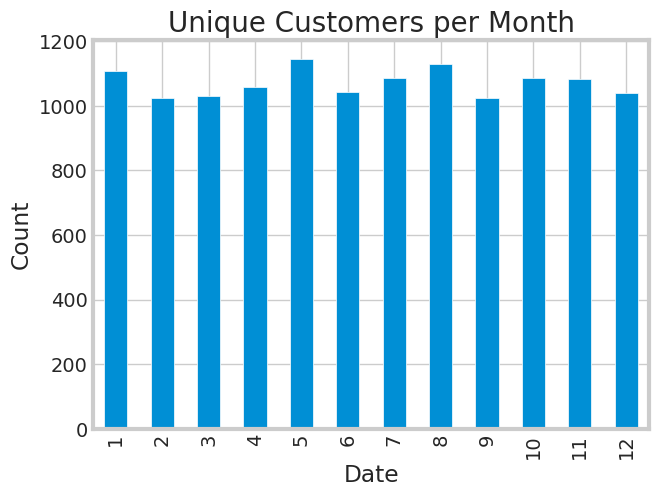

In [10]:
ax = df['Member_number'].groupby([df['Date'].dt.month]).nunique().plot(kind='bar')
ax.set_title('Unique Customers per Month', size=20)
ax.set_ylabel('Count');

To build association rules for the products being sold, we'll need to transform our data to a form where each row represents a single 'basket' or order, and each product is represented as a one-hot encoded column. To address the first issue (and partially, the second issue), we'll need to apply the opposite of `melt` (lab 4), which is called `pivot`.

The transactions in this data are split over multiple rows, the primary key for a single order being both `'Member_number'` and `'Date'`. We'll also drop any duplicate items in a single purchase, since we're only interested if the item appears or not and also because `pivot` will raise an error if there any duplicates.

**Note**: if each row was already complete and had the columns we are interested in, then we could use `pd.get_dummies` for the columns we're interested in finding associations for to one-hot encode the categorical data and convert the binary columns (e.g., Yes/No) to 0s and 1s.

In [11]:
enc_df = df[['Member_number', 'Date', 'itemDescription']].drop_duplicates().pivot(index=['Member_number', 'Date'], columns='itemDescription', values='itemDescription')
enc_df

itemDescription          Instant food products UHT-milk abrasive cleaner  \
Member_number Date                                                         
1000          2014-06-24                   NaN      NaN              NaN   
              2015-03-15                   NaN      NaN              NaN   
              2015-05-27                   NaN      NaN              NaN   
              2015-07-24                   NaN      NaN              NaN   
              2015-11-25                   NaN      NaN              NaN   
...                                        ...      ...              ...   
4999          2015-05-16                   NaN      NaN              NaN   
              2015-12-26                   NaN      NaN              NaN   
5000          2014-03-09                   NaN      NaN              NaN   
              2014-11-16                   NaN      NaN              NaN   
              2015-02-10                   NaN      NaN              NaN   

itemDescription          artif. sweetener baby cosmetics bags baking powder  \
Member_number Date                                                            
1000          2014-06-24              NaN            NaN  NaN           NaN   
              2015-03-15              NaN            NaN  NaN           NaN   
              2015-05-27              NaN            NaN  NaN           NaN   
              2015-07-24              NaN            NaN  NaN           NaN   
              2015-11-25              NaN            NaN  NaN           NaN   
...                                   ...            ...  ...           ...   
4999          2015-05-16              NaN            NaN  NaN           NaN   
              2015-12-26              NaN            NaN  NaN           NaN   
5000          2014-03-09              NaN            NaN  NaN           NaN   
              2014-11-16              NaN            NaN  NaN           NaN   
              2015-02-10              NaN            NaN  NaN           NaN   

itemDescription          bathroom cleaner beef berries  ... turkey vinegar  \
Member_number Date                                      ...                  
1000          2014-06-24              NaN  NaN     NaN  ...    NaN     NaN   
              2015-03-15              NaN  NaN     NaN  ...    NaN     NaN   
              2015-05-27              NaN  NaN     NaN  ...    NaN     NaN   
              2015-07-24              NaN  NaN     NaN  ...    NaN     NaN   
              2015-11-25              NaN  NaN     NaN  ...    NaN     NaN   
...                                   ...  ...     ...  ...    ...     ...   
4999          2015-05-16              NaN  NaN     NaN  ...    NaN     NaN   
              2015-12-26              NaN  NaN     NaN  ...    NaN     NaN   
5000          2014-03-09              NaN  NaN     NaN  ...    NaN     NaN   
              2014-11-16              NaN  NaN     NaN  ...    NaN     NaN   
              2015-02-10              NaN  NaN     NaN  ...    NaN     NaN   

itemDescription          waffles  whipped/sour cream whisky white bread  \
Member_number Date                                                        
1000          2014-06-24     NaN                 NaN    NaN         NaN   
              2015-03-15     NaN                 NaN    NaN         NaN   
              2015-05-27     NaN                 NaN    NaN         NaN   
              2015-07-24     NaN                 NaN    NaN         NaN   
              2015-11-25     NaN                 NaN    NaN         NaN   
...                          ...                 ...    ...         ...   
4999          2015-05-16     NaN  whipped/sour cream    NaN         NaN   
              2015-12-26     NaN                 NaN    NaN         NaN   
5000          2014-03-09     NaN                 NaN    NaN         NaN   
              2014-11-16     NaN                 NaN    NaN         NaN   
              2015-02-10     NaN                 NaN    NaN         

Since `NaN` represents items that were *not* bought in the transaction, and non-`NaN` represents items that *were* purchased, we can use `notnull()` to get our data in the final form necessary for using it in the association rule algorithm.

In [12]:
enc_df = enc_df.notnull()
enc_df

itemDescription           Instant food products  UHT-milk  abrasive cleaner  \
Member_number Date                                                            
1000          2014-06-24                  False     False             False   
              2015-03-15                  False     False             False   
              2015-05-27                  False     False             False   
              2015-07-24                  False     False             False   
              2015-11-25                  False     False             False   
...                                         ...       ...               ...   
4999          2015-05-16                  False     False             False   
              2015-12-26                  False     False             False   
5000          2014-03-09                  False     False             False   
              2014-11-16                  False     False             False   
              2015-02-10                  False     False             False   

itemDescription           artif. sweetener  baby cosmetics   bags  \
Member_number Date                                                  
1000          2014-06-24             False           False  False   
              2015-03-15             False           False  False   
              2015-05-27             False           False  False   
              2015-07-24             False           False  False   
              2015-11-25             False           False  False   
...                                    ...             ...    ...   
4999          2015-05-16             False           False  False   
              2015-12-26             False           False  False   
5000          2014-03-09             False           False  False   
              2014-11-16             False           False  False   
              2015-02-10             False           False  False   

itemDescription           baking powder  bathroom cleaner   beef  berries  \
Member_number Date                                                          
1000          2014-06-24          False             False  False    False   
              2015-03-15          False             False  False    False   
              2015-05-27          False             False  False    False   
              2015-07-24          False             False  False    False   
              2015-11-25          False             False  False    False   
...                                 ...               ...    ...      ...   
4999          2015-05-16          False             False  False    False   
              2015-12-26          False             False  False    False   
5000          2014-03-09          False             False  False    False   
              2014-11-16          False             False  False    False   
              2015-02-10          False             False  False    False   

itemDescription           ...  turkey  vinegar  waffles  whipped/sour cream  \
Member_number Date        ...                                                 
1000          2014-06-24  ...   False    False    False               False   
              2015-03-15  ...   False    False    False               False   
              2015-05-27  ...   False    False    False               False   
              2015-07-24  ...   False    False    False               False   
              2015-11-25  ...   False    False    False               False   
...                       ...     ...      ...      ...                 ...   
4999          2015-05-16  ...   False    False    False                True   
              2015-12-26  ...   False    False    False               False   
5000          2014-03-09  ...   False    False    False               False   
              2014-11-16  ...   False    False    False               False   
              2015-02-10  ...   False    False    False               False   

itemDescription           whisky  white brea

With each row now representing a single 'basket' of items, we can perform some additional visualizations.

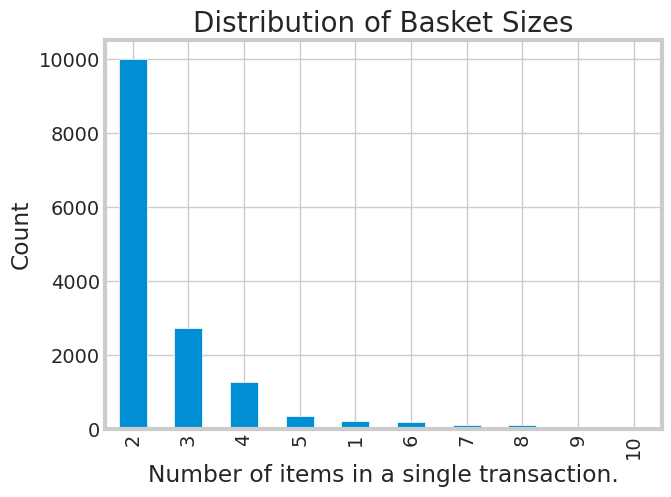

In [13]:
basket_sizes = enc_df.sum(axis=1)
ax = basket_sizes.value_counts().plot.bar()
ax.set_title('Distribution of Basket Sizes', size=20)
ax.set_ylabel('Count')
ax.set_xlabel('Number of items in a single transaction.');

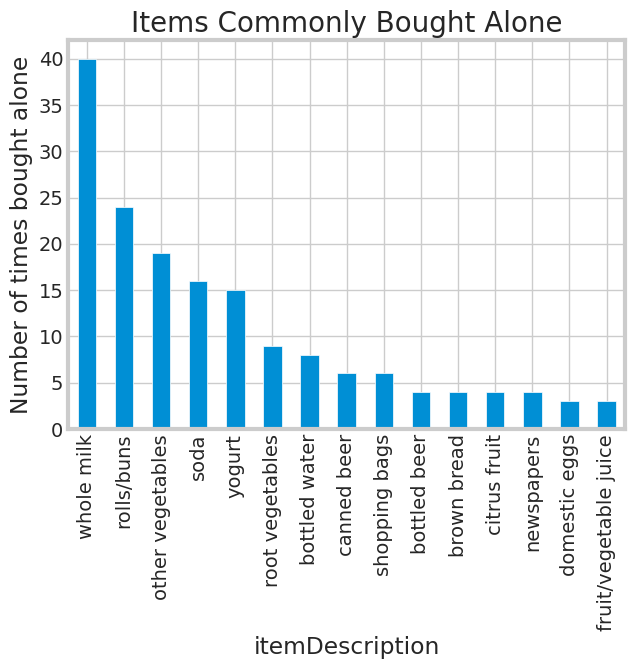

In [14]:
single_items = enc_df[basket_sizes == 1].sum()
ax = single_items.nlargest(15).plot.bar()
ax.set_title('Items Commonly Bought Alone', size=20)
ax.set_ylabel('Number of times bought alone');

## Association Rule Mining

Support is essentially the percentage of orders/transactions containing the itemset, given by the following formula:

$$\mathrm{Support}(A \Rightarrow B)=\dfrac{|A \cup B|}{n}$$

The first step in association rule mining is getting the frequent item sets in the data. We don’t want to set the standard high, otherwise the number of possible association rules is limited. However, keep in mind that the lower this threshold is set, the more spurious and non-frequent associations are extracted, which is usually undesirable. Usually, we can start with a high `min_support` threshold like 0.5 (50%), and reduce it till we get a useful amount of itemsets.

In [15]:
#uncomment the below code if you are working on a local repo, prob the older version (Install mlxtend)
#!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

freq_items = apriori(enc_df, min_support=0.005, use_colnames=True)
freq_items

,support,itemsets
0,0.021386,(UHT-milk)
1,0.008087,(baking powder)
2,0.033950,(beef)
3,0.021787,(berries)
4,0.016574,(beverages)
...,...,...
121,0.011629,"(whole milk, soda)"
122,0.005814,"(yogurt, soda)"
123,0.008220,"(tropical fruit, whole milk)"
124,0.005213,"(tropical fruit, yogurt)"


Given two item sets, A and B, confidence measures the percentage of times that B was purchased, given that A was purchased. In other words, it measures how *confident* we are that B would follow A. This is calculated using the following formula:

$$\mathrm{Confidence}(A \Rightarrow B)=\dfrac{\mathrm{Support}(A \cup B)}{\mathrm{Support}(A)}$$

The next step is building the association rules out of the frequent item sets we got from the last step. There are several metrics we can use to filter the association rules. We'll try confidence first. Again, we can start with a high value like 0.75 (75%) and reduce it till we can get interesting association rules.

In [16]:
association_rules(freq_items, metric='confidence', min_threshold=0.1, num_itemsets = len(enc_df)).sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,1.0,-0.000005,0.999874,-0.000702,0.036469,-0.000126,0.101549
14,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,1.0,-0.000575,0.988811,-0.063965,0.042784,-0.011316,0.102551
7,(newspapers),(whole milk),0.038896,0.157923,0.005614,0.144330,0.913926,1.0,-0.000529,0.984114,-0.089246,0.029360,-0.016142,0.089939
4,(domestic eggs),(whole milk),0.037091,0.157923,0.005280,0.142342,0.901341,1.0,-0.000578,0.981834,-0.102072,0.027827,-0.018503,0.087887
6,(frankfurter),(whole milk),0.037760,0.157923,0.005280,0.139823,0.885388,1.0,-0.000683,0.978958,-0.118576,0.027729,-0.021494,0.086628
5,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,1.0,0.000536,1.016420,0.108146,0.033261,0.016154,0.089214
11,(pork),(whole milk),0.037091,0.157923,0.005012,0.135135,0.855703,1.0,-0.000845,0.973652,-0.149027,0.026381,-0.027061,0.083437
10,(pip fruit),(whole milk),0.049054,0.157923,0.006616,0.134877,0.854071,1.0,-0.001130,0.973362,-0.152310,0.033022,-0.027367,0.088387
3,(citrus fruit),(whole milk),0.053131,0.157923,0.007151,0.134591,0.852259,1.0,-0.001240,0.973040,-0.154748,0.035070,-0.027707,0.089936
15,(shopping bags),(whole milk),0.047584,0.157923,0.006349,0.133427,0.844887,1.0,-0.001166,0.971732,-0.161610,0.031879,-0.029090,0.086815


Since whole milk is the most commonly purchased item, it also appears as the consequent in many of the association rules. One useful association we can conclude from here is frankfurter and other vegetables. Though it appears that confidence is low for many of the itemsets; this is likely due to this store/dataset having a very small number of items per order (see the basket size visual above).

# Extra Reading

### Lift Metric

We can consider using lift, which, on the other hand, indicates if there is a relationship between itemsets A and B. The value can be interpreted as such:

- lift = 1 implies no relationship between A and B (i.e., A and B occur together only by chance)

- lift > 1 implies that there is a positive relationship between A and B. (i.e., A and B occur together more often than random)

- lift < 1 implies that there is a negative relationship between A and B. (i.e., A and B occur together less often than random)

$$\mathrm{Lift}(A, B) = \mathrm{Lift}(B, A) = \dfrac{\mathrm{Support}(A \cup B)}{\mathrm{Support}(A) \times \mathrm{Support}(B)}$$

In [17]:
association_rules(freq_items, metric='lift', min_threshold=1, num_itemsets = len(enc_df)).sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,1.0,0.000536,1.016420,0.108146,0.033261,0.016154,0.089214
1,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,1.0,0.000536,1.004579,0.118536,0.033261,0.004558,0.089214
5,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,1.0,0.000565,1.010345,0.104587,0.040913,0.010239,0.081082
4,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,1.0,0.000565,1.007049,0.107508,0.040913,0.007000,0.081082
3,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,1.0,0.000088,1.000963,0.016341,0.039259,0.000962,0.079906
2,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,1.0,0.000088,1.001613,0.015702,0.039259,0.001611,0.079906


Buying one of frankfurter or other vegetables *lifts* the chance of the other being purchased. The same goes for sausage and yogurt, as well as sausage and soda.